<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/MF_LBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!apt-get update
!apt-get install -y git build-essential nvidia-cuda-toolkit

# Verify CUDA installation
!nvcc --version

# Clone the repository
!git clone https://github.com/Mahmoud-Sedahmed/MF-LBM-CUDA.git
%cd MF-LBM-CUDA

# Edit Makefile for CUDA paths and compute capability
!sed -i 's|COMPUTE_CAPABILITY := .*|COMPUTE_CAPABILITY := 80|' Makefile
!sed -i 's|CUDA_LIBRARY_LOCATION := .*|CUDA_LIBRARY_LOCATION := /usr/local/cuda/lib64|' Makefile
!sed -i 's|CUDA_LNK_PATH := .*|CUDA_LNK_PATH := /usr/local/cuda/lib64|' Makefile
!sed -i 's|BUILD := .*|BUILD := release|' Makefile

# Set solver precision to single precision
!sed -i 's|#define PRECISION (.*)|#define PRECISION (SINGLE_PRECISION)|' includes/solver_precision.h

# Compile the program
!make

# Prepare input files for the test case
!cp input/simulation_control.txt .
!cp input/geometry/bentheimer_240_240_240.dat Geometry_File_Path.txt

# Run the simulation
!./MF_LBM_CUDA




Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [910 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,119 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,552 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,396 kB

ModuleNotFoundError: No module named 'vtk'

In [2]:
!pip install vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 19.6 MB/s eta 0:00:00


In [6]:
# Visualize results
import vtk
print("VTK version:", vtk.vtkVersion.GetVTKVersion())
from vtkmodules.util.numpy_support import vtk_to_numpy
import numpy as np
import matplotlib.pyplot as plt

def visualize_vtk(file_path):
    reader = vtk.vtkStructuredPointsReader()
    reader.SetFileName(file_path)
    reader.Update()

    output = reader.GetOutput()
    dims = output.GetDimensions()

    scalar_range = output.GetScalarRange()
    scalar_data = vtk_to_numpy(output.GetPointData().GetScalars()).reshape(dims, order='F')

    slice_index = dims[2] // 2
    plt.imshow(scalar_data[:, :, slice_index], cmap='jet', vmin=scalar_range[0], vmax=scalar_range[1])
    plt.colorbar()
    plt.title('Flow Visualization')
    plt.show()

# Visualize the VTK output
vtk_file_path = "results/out3.field_data/flow_data_000001.vtk"
visualize_vtk(vtk_file_path)

VTK version: 9.3.1


AttributeError: 'NoneType' object has no attribute 'GetDataType'

In [8]:
!pip install pyvista

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.1 MB/s eta 0:00:00


In [9]:
import pyvista as pv

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000000001.vtk")  # Replace with your actual file path

# Load the walls to overlay
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter
plotter = pv.Plotter()

# Add the first phase
phase1 = phase_data.threshold(above_value=0.5)  # Assume phase1 is above 0.5 threshold
plotter.add_mesh(phase1, color='orange', opacity=0.8)

# Add the second phase
phase2 = phase_data.threshold(below_value=0.5)  # Assume phase2 is below 0.5 threshold
plotter.add_mesh(phase2, color='cyan', opacity=0.8)

# Overlay the porous structure
plotter.add_mesh(walls_data, color='tan', opacity=0.3)

# Customize the plot
plotter.show_grid()
plotter.background_color = 'white'
plotter.add_axes()

# Show the plot
plotter.show()


/usr/local/lib/python3.10/dist-packages/pyvista/plotting/plotter.py:159: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


TypeError: DataSetFilters.threshold() got an unexpected keyword argument 'above_value'

In [ ]:
import pyvista as pv

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range or known values
# Since phi represents phase distribution, determine threshold around the midpoint or specific saturation value
threshold_value = (phi_max - phi_min) * 0.5 + phi_min  # This will place the threshold in the middle of the range

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter
plotter = pv.Plotter()

# Extract and visualize the first fluid phase
phase1 = phase_data.threshold(value=threshold_value, scalars='phi', invert=False)
plotter.add_mesh(phase1, color='orange', opacity=0.7, show_scalar_bar=False)

# Extract and visualize the second fluid phase
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
plotter.add_mesh(phase2, color='cyan', opacity=0.7, show_scalar_bar=False)

# Overlay the porous structure
plotter.add_mesh(walls_data, color='tan', opacity=0.3)

# Customize plot settings
plotter.show_grid()
plotter.background_color = 'white'
plotter.add_axes()

# Display the plot
plotter.show()


Scalar names in the dataset: ['phi']
Scalar range for 'phi': -1.0034077 1.0009024


/usr/local/lib/python3.10/dist-packages/pyvista/plotting/plotter.py:159: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


In [1]:
# Install necessary packages
!pip install pyvista vtk pyvistaqt

# Start a virtual framebuffer
import pyvista as pv
pv.start_xvfb()

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range
threshold_value = (phi_max - phi_min) * 0.5 + phi_min  # Midpoint of the scalar range

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter
plotter = pv.Plotter(off_screen=True)  # Use off-screen rendering to prevent crashes

# Extract and visualize the first fluid phase
phase1 = phase_data.threshold(value=threshold_value, scalars='phi', invert=False)
plotter.add_mesh(phase1, color='orange', opacity=0.7, show_scalar_bar=True)

# Extract and visualize the second fluid phase
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
plotter.add_mesh(phase2, color='cyan', opacity=0.7, show_scalar_bar=True)

# Overlay the porous structure
plotter.add_mesh(walls_data, color='tan', opacity=0.3)

# Customize plot settings
plotter.show_grid()
plotter.background_color = 'white'
plotter.add_axes()

# Save the plot as a screenshot
plotter.show(screenshot='output_image.png')  # This will save the plot as an image

# Display the saved image using matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('output_image.png')
plt.imshow(img)
plt.axis('off')
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.5 MB/s eta 0:00:00


OSError: Please install Xvfb with:

Debian
$ sudo apt install libgl1-mesa-glx xvfb

CentOS / RHL
$ sudo yum install libgl1-mesa-glx xvfb



In [2]:
!apt-get update
!apt-get install -y xvfb
!pip install pyvista vtk pyvistaqt


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,396 kB]
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,422 kB]
Fetched 4,074 kB in 2s (2,221 kB/s)
Re

In [3]:
import os
os.system('Xvfb :99 -screen 0 1024x768x24 &')  # Start Xvfb
os.environ['DISPLAY'] = ':99.0'  # Set DISPLAY environment variable


Scalar names in the dataset: ['phi']
Scalar range for 'phi': -1.0034077 1.0009024


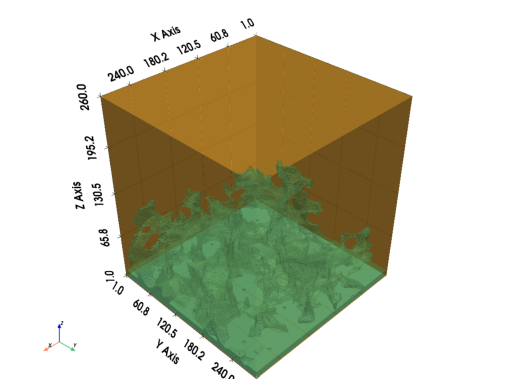

In [4]:
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Start PyVista's virtual framebuffer for off-screen rendering
pv.start_xvfb()

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range
threshold_value = (phi_max - phi_min) * 0.5 + phi_min  # Midpoint of the scalar range

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter for off-screen rendering
plotter = pv.Plotter(off_screen=True)

# Extract and visualize the first fluid phase
phase1 = phase_data.threshold(value=threshold_value, scalars='phi', invert=False)
plotter.add_mesh(phase1, color='orange', opacity=0.7, show_scalar_bar=True)

# Extract and visualize the second fluid phase
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
plotter.add_mesh(phase2, color='cyan', opacity=0.7, show_scalar_bar=True)

# Overlay the porous structure
plotter.add_mesh(walls_data, color='tan', opacity=0.3)

# Customize plot settings
plotter.show_grid()
plotter.background_color = 'white'
plotter.add_axes()

# Save the plot as a screenshot
plotter.show(screenshot='output_image.png')  # Save plot as an image

# Display the saved image using matplotlib
img = mpimg.imread('output_image.png')
plt.imshow(img)
plt.axis('off')
plt.show()


Scalar names in the dataset: ['phi']
Scalar range for 'phi': -1.0034077 1.0009024


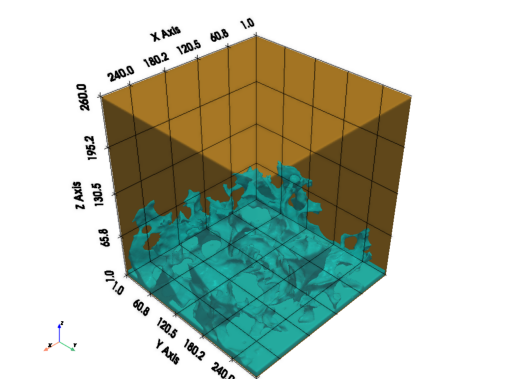

In [7]:
import os
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure Xvfb is running
os.system('Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99.0'

# Start PyVista's virtual framebuffer
pv.start_xvfb()

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range
threshold_value = 0.0  # Threshold for separating phases

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter for off-screen rendering
plotter = pv.Plotter(off_screen=True)

# Extract and visualize the first fluid phase
phase1 = phase_data.threshold(value=threshold_value, scalars='phi', invert=False)
phase1_poly = phase1.extract_geometry()  # Convert to PolyData for smoothing
phase1_smoothed = phase1_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(phase1_smoothed, color='orange', opacity=0.8, show_scalar_bar=False, specular=0.3)

# Extract and visualize the second fluid phase
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
phase2_poly = phase2.extract_geometry()  # Convert to PolyData for smoothing
phase2_smoothed = phase2_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(phase2_smoothed, color='cyan', opacity=0.8, show_scalar_bar=False, specular=0.3)

# Overlay the porous structure
walls_poly = walls_data.extract_geometry()  # Convert to PolyData for smoothing
walls_smoothed = walls_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(walls_smoothed, color='gray', opacity=0.2)

# Customize plot settings
plotter.show_grid()  # Enable the grid with default settings
plotter.background_color = 'white'
plotter.add_axes(interactive=False)  # Disable interactive axes

# Set a better camera angle and lighting
plotter.view_isometric()
plotter.enable_eye_dome_lighting()  # Enhance depth perception with lighting

# Save the plot as a screenshot
plotter.show(screenshot='output_image.png')  # Save plot as an image

# Display the saved image using matplotlib
img = mpimg.imread('output_image.png')
plt.imshow(img)
plt.axis('off')
plt.show()


Scalar names in the dataset: ['phi']
Scalar range for 'phi': -1.0034077 1.0009024


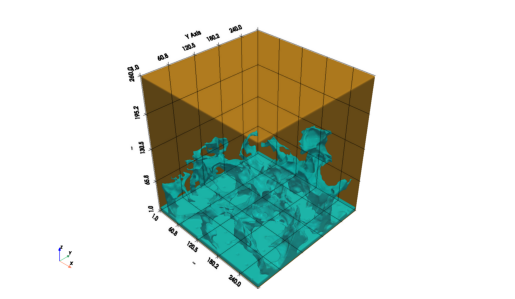

In [9]:
import os
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure Xvfb is running
os.system('Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99.0'

# Start PyVista's virtual framebuffer
pv.start_xvfb()

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range
threshold_value = 0.0  # Threshold for separating phases

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter for off-screen rendering
plotter = pv.Plotter(off_screen=True, window_size=[1920, 1080])

# Extract and visualize the first fluid phase
phase1 = phase_data.threshold(value=threshold_value, scalars='phi', invert=False)
phase1_poly = phase1.extract_geometry()  # Convert to PolyData for smoothing
phase1_smoothed = phase1_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(phase1_smoothed, color='orange', opacity=0.8, show_scalar_bar=False, specular=0.3)

# Extract and visualize the second fluid phase
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
phase2_poly = phase2.extract_geometry()  # Convert to PolyData for smoothing
phase2_smoothed = phase2_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(phase2_smoothed, color='cyan', opacity=0.8, show_scalar_bar=False, specular=0.3)

# Overlay the porous structure
walls_poly = walls_data.extract_geometry()  # Convert to PolyData for smoothing
walls_smoothed = walls_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(walls_smoothed, color='gray', opacity=0.15)

# Customize plot settings
plotter.background_color = None  # Set transparent background
plotter.show_grid()  # Disable the grid for a cleaner look
plotter.add_axes(interactive=False)  # Disable interactive axes

# Adjust the camera position for better angle
plotter.camera_position = [(300, 300, 300), (120, 120, 130), (0, 0, 1)]
plotter.view_vector((1, -1, 1))  # Adjust view vector for better perspective

# Enable enhanced lighting
plotter.enable_eye_dome_lighting()  # Enhance depth perception with lighting

# Save the plot as a screenshot
plotter.show(screenshot='output_image.png')  # Save plot as an image

# Display the saved image using matplotlib
img = mpimg.imread('output_image.png')
plt.imshow(img)
plt.axis('off')
plt.show()


Scalar names in the dataset: ['phi']
Scalar range for 'phi': -1.0034077 1.0009024


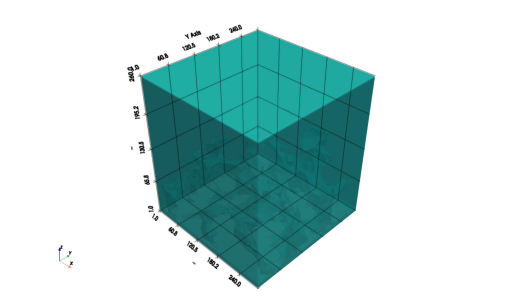

In [13]:
import os
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure Xvfb is running
os.system('Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99.0'

# Start PyVista's virtual framebuffer
pv.start_xvfb()

# Load the phase distribution data
phase_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/phase_distribution/small_0000500001.vtk")

# Inspect the scalar data to determine the range
print("Scalar names in the dataset:", phase_data.array_names)
phi_array = phase_data.get_array("phi")
phi_min, phi_max = phi_array.min(), phi_array.max()
print("Scalar range for 'phi':", phi_min, phi_max)

# Determine a threshold based on the scalar range
threshold_value = 0.0  # Threshold for separating phases

# Load the porous structure
walls_data = pv.read("/content/MF-LBM-CUDA/results/out3.field_data/walls_bin.vtk")

# Create a plotter for off-screen rendering
plotter = pv.Plotter(off_screen=True, window_size=[1920, 1080])

# Extract and visualize the second fluid phase (cyan)
phase2 = phase_data.threshold(value=threshold_value, scalars='phi', invert=True)
phase2_poly = phase2.extract_geometry()  # Convert to PolyData for smoothing
phase2_smoothed = phase2_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(phase2_smoothed, color='cyan', opacity=0.8, show_scalar_bar=False, specular=0.3)

# Overlay the porous structure
walls_poly = walls_data.extract_geometry()  # Convert to PolyData for smoothing
walls_smoothed = walls_poly.smooth(n_iter=50, relaxation_factor=0.1)
plotter.add_mesh(walls_smoothed, color='gray', opacity=0.15)

# Customize plot settings
plotter.background_color = 'white'  # Set the background color to white
plotter.show_grid()  # Disable the grid for a cleaner look
plotter.add_axes(interactive=False)  # Disable interactive axes

# Adjust the camera position for better angle
plotter.camera_position = [(300, 300, 300), (120, 120, 130), (0, 0, 1)]
plotter.view_vector((1, -1, 1))  # Adjust view vector for better perspective

# Enable enhanced lighting
plotter.enable_eye_dome_lighting()  # Enhance depth perception with lighting

# Save the plot as a screenshot
plotter.show(screenshot='output_image.png')  # Save plot as an image

# Display the saved image using matplotlib
img = mpimg.imread('output_image.png')
plt.imshow(img)
plt.axis('off')
plt.show()
